# Проект "Машинное обучение для анализа и предсказания оттока клиентов"


## Описание проекта

Для расчетов использовались данные фитнесс-клуба о клиентах. Дана таблица, которая содержат данные на месяц до оттока и факт оттока на определённый месяц.

**Цель:** провести анализ и подготовить план действий по удержанию клиентов.

**Задачи**
 - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
 - сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

  1) выделить целевые группы клиентов;
  
  2) предложить меры по снижению оттока;
  
  3) определить другие особенности взаимодействия с клиентами.

## 1. Обзор данных.

**Расшифровка таблицы**

 - `'Churn'` — факт оттока в текущем месяце;
 
 Текущие поля в датасете:
 
Данные пользователя за предыдущий до проверки факта оттока месяц:

 - `'gender'` — пол
 - `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр
 - `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
 - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
 - `'Phone'` — наличие контактного телефона
 - `'Age'` — возраст
 - `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах)
 
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента

 - `'Contract_period'` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
 - `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах)
 - `'Group_visits'` — факт посещения групповых занятий
 - `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента
 - `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц
 - `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон


In [1]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

**Загрузка данных**

- загружаем данные
- смотрим шапку таблицы
- размер таблицы и типы данных

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')
display(gym.head())
gym.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


**Вывод:**

- Размер таблицы для анализа 4000 наблюдений и 13 признаков для каждого клиента. Одна колонка с фактом попадения клиента в отток
- Типы данных подходят для исследования
- Пропусков в данных при беглом осмотре информации нет
- Для дальнейшего удобства во время предобработки стоит снизить регистр названий колонок.

## EDA

1. Проверка пропусков и дубликатов в данных
2. Смена названий колонок для удобства
3. Оценка средний значений признаков по всем данным и с разбивкой по группам оттока.
4. Распределение признаков по группам оттока 
5. Оценка взаимосвязанности между признаками

Оценка пропусков и дубликатов, смена регистра названий колонок в данных.

In [3]:
print('Полных дубликатов:', gym.duplicated().sum())
print()
print('Пропущенных данных в датасете:')
gym.isnull().sum()


Полных дубликатов: 0

Пропущенных данных в датасете:


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [4]:
gym.columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn']
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
gym.describe()


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Оценка средний значений признаков в датасете.
 - Часть признаков дискретные (1/0), оценка средних значений может говорить о количестве еденичек. 
   - По полу, например, среднее 0.5 - мужчин и жензин примерно одинаковое количество.  
   - Среди оценки близости к клубу 0.8, если предположить что 1 = клиент живет близко к клубу, то значит для большинства клиентов клуб близко (удобно) расположен. *(в дальнейшем за неимением лучшего будем предполагать что 1 это положительное значение (есть телефон, живет близко и т.д.)*
   - Так же большинство клиентов (0.9) дают свой номер телефона. 
   - Пришедших с другом (0.3) меньше половины
   - По партнерскому абонименту (0.48) пришло около половины всех клиентов.
   - Групповые занятия так же посещают примерно поровну.
   
- В некоторых признаках присуствтует очень большой разброс и по оценке среднего и квартилей сложно понять общую картину. Мы позднее обратимся к графикам, для того что бы лучше понять эти характеристики.
  - Контракты больше всего заключают на 1 месяц (первые три квартиля), хотя в среднем показывают 4 месяца. Так происходит из-за абониментов на полгода/год.  С месяцем до окончания контракта наблюдается похожая ситуация.
  - Жизненный цикл в среднем составляет 3 месяца. 
  - Посещают центр чаще всего 1-2 раза в неделю. Клиенты, видимо, редко изменяют своим привычкам: средняя недельная посещаемость за последний месяц очень схожа с этим же показателем за весь жизненный срок
  
  - Тратят в клубе в среднем около 150 единиц. Данные сильно варьируются , есть клиенты, которые не тратятся на дополнительные услуги вообще или очень мало, есть те, кто тратит в 2 раза больше среднего чека. Такие данные требуют дополнительного осмотра.
  
  - Возраст клиентов клуба варьируется от 18 до 41, в среднем большую часть клиентов составляют люди 29 лет.

In [6]:
gym['churn'].value_counts()
# 1 - ушедшие, 0 - остались

0    2939
1    1061
Name: churn, dtype: int64

*Оценка оттока*

Мы будем считать что 1 отмечает клиентов, ушедших в отток, а 0 - оставшихся.

In [7]:
stay = gym.query('churn == 0')
left = gym.query('churn == 1')
print('Средние значения среди оставшихся')
display(stay.mean())
print('Средниче значения среди ушедших')
display(left.mean())

Средние значения среди оставшихся


gender                                 0.510037
near_location                          0.873086
partner                                0.534195
promo_friends                          0.353522
phone                                  0.903709
contract_period                        5.747193
group_visits                           0.464103
age                                   29.976523
avg_additional_charges_total         158.445715
month_to_end_contract                  5.283089
lifetime                               4.711807
avg_class_frequency_total              2.024876
avg_class_frequency_current_month      2.027882
churn                                  0.000000
dtype: float64

Средниче значения среди ушедших


gender                                 0.510839
near_location                          0.768143
partner                                0.355325
promo_friends                          0.183789
phone                                  0.902922
contract_period                        1.728558
group_visits                           0.268615
age                                   26.989632
avg_additional_charges_total         115.082899
month_to_end_contract                  1.662582
lifetime                               0.990575
avg_class_frequency_total              1.474995
avg_class_frequency_current_month      1.044546
churn                                  1.000000
dtype: float64

**Оценка средних значений по группам отток/оставшиеся клиенты**

- Часть данных схожа в обеих группах (пол, близкое расположение, данные о телефоне)

При сранении только средних значений в глаза бросаются следующие отличия:

- Следи ушедших клиентов средний возраст ниже, но не значительно (около 4 лет)
- Они тратят чуть меньше денег на дополнительные услуги
- Чаще всего они ходят реже (1 занятие в неделю против 2 занятий у постоянных клиентов)
- Реже посещают групповые занятия.
- Так же показатели их жизненного цикла, срока до окончания действия абонимента и средней продолжительности абонимента меньше, около 1 месяца - среди постоянных клиентов, судя по показателям, абонимент на 3-6 месяцев более популярен.

**Рассмотрим признаки с разбивкой на постоянных и ушедших клиентов**


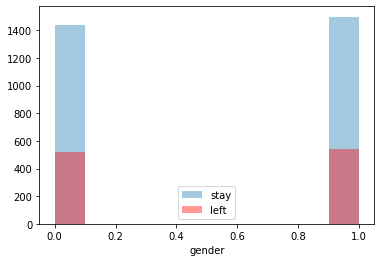

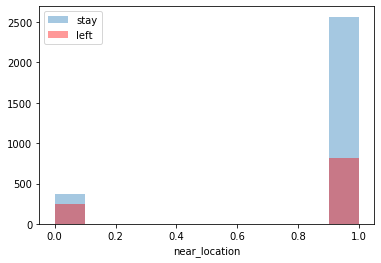

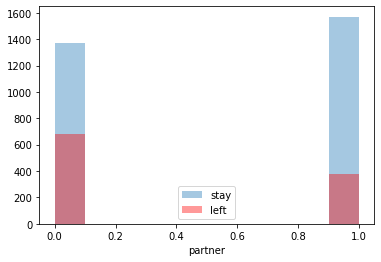

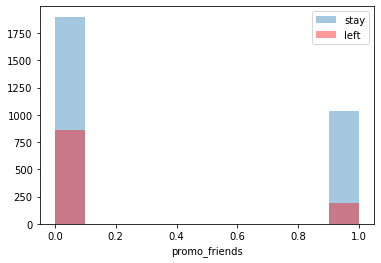

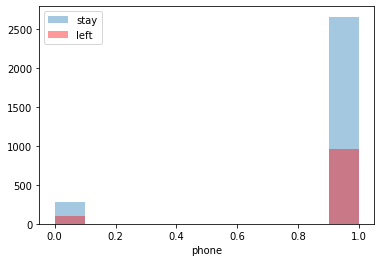

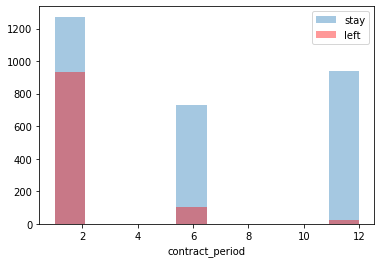

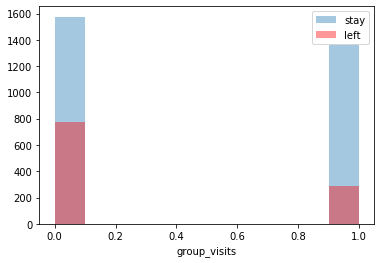

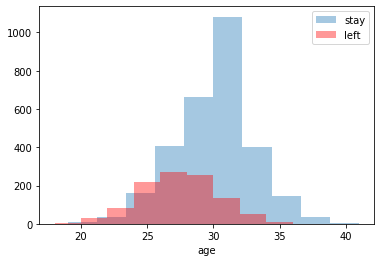

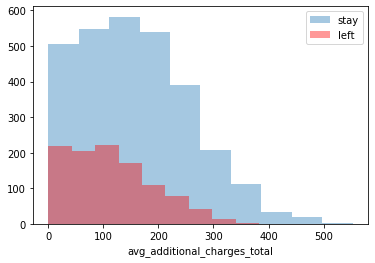

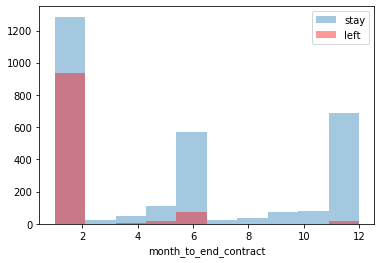

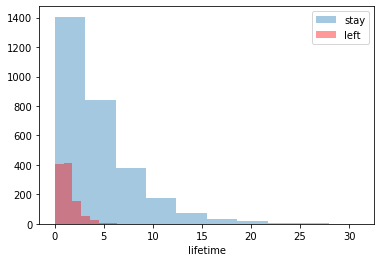

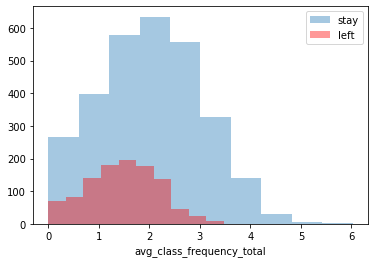

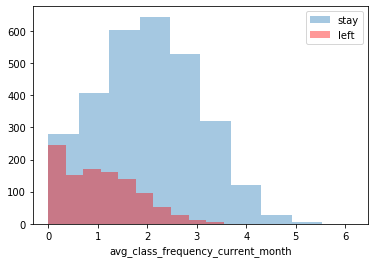

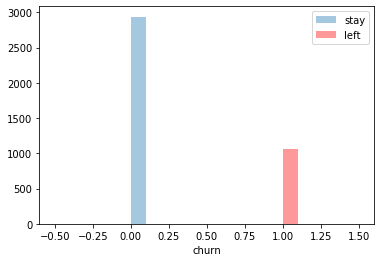

In [8]:
for col in gym.columns:
    sns.distplot(stay[col], label = 'stay',  bins = 10, kde = False)
    sns.distplot(left[col], label = 'left', color = 'red', bins = 10, kde = False)
    plt.legend()
    plt.show()

**По графикам можно сделать общие выводы о различии групп постоянных клиентов и клиентов из оттока**

- Среди живущих рядом с центром клиентов больше постоянных. Из тех, для кого расположение центра не так удобно, больше уходящих.
- Так же больше постоянных среди клиентов по партнерскому абонементу
- Среди тех, кто пришел по своей инициативе поровну клиентов из обеих групп, а вот среди пришедших с другом больше постоянных. Заниматься с приятилями веселее и проще не бросать, судя по всему.
- Абонемент на 6 и 12 месяцев гораздо чаще берут постоянные клиенты. Это, возможно, помогает им не бросать. А вот из тех, кто заключил контракт на один месяц больше половины попавших в отток.
- Клиенты, которые не ходят на групповые занятия поровну делятся на обе группы. А вот среди тех, кто ходит больше постоянных. Возможно, вовлекаясь в групповые занятия, проще поддерживать регулярные занятия.
- Как уже говорилось выше, в отток попадают клиенты в среднем моложе постоянных.
- Уходящие меньше тратят на дополнительные расходы в клубе. Это может быть связано с их неуверенностью в финансах (моложе возраст, контракты часто на месяц), а может быть с тем, что они реже посещают.
- Больше всего попадают в отток клиенты, у которых до окончания срока контракта остался месяц. Это скорее всего связано с тем, что они часто берут контракт именно на 1 месяц.
- Жизненный цикл уходящих меньше. Если клиент с вами уже 5 месяцев, вероятность его попадения в отток ниже.
- Как говорилось ранее, постоянные клиенты в среднем в неделю чаще приходят на занятия.

**Оценим корреляцию признаков**

В данном случае будем обращать внимание на признаки, сильнее всего коррелирующие между собой, так как они могут помешать алгоритму сделать правильное "предсказание".

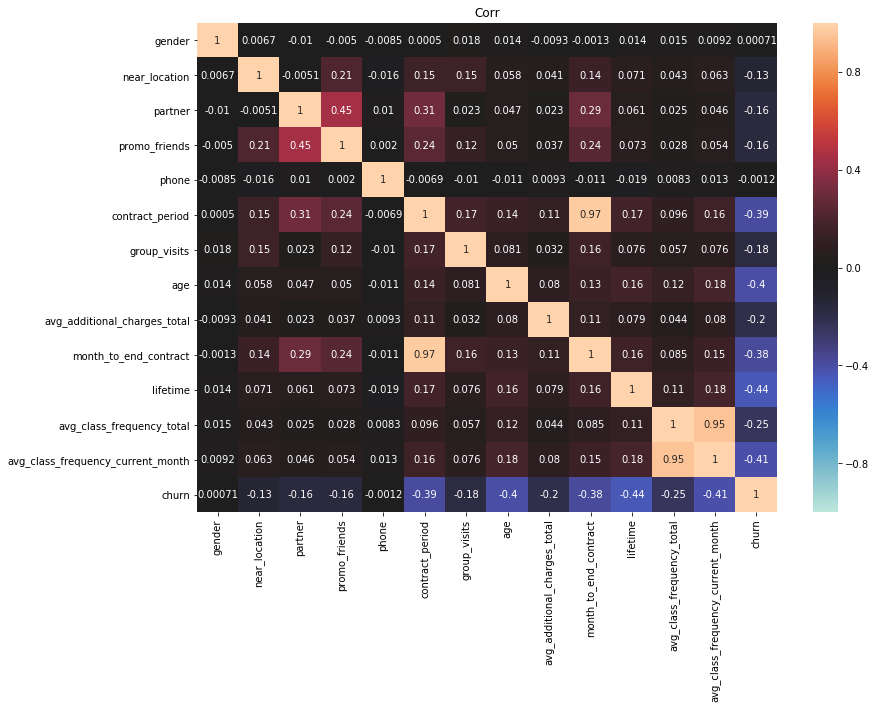

In [9]:
gym_corr = gym.corr()

plt.figure(figsize=(13, 9))
plt.title('Corr')
sns.heatmap(gym_corr, annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0)
plt.show()

In [10]:
gym.drop('contract_period', axis = 1, inplace = True) # убираем один из пары коррелирующих признаков

gym.drop('avg_class_frequency_current_month', axis = 1, inplace = True) 

**Мультиколлинеарные признаки**

Матрица корреляций выявила две пары сильно связанных признаков.

1. Срок абонемента клиента и остаток месяцев для его посещения. Это логично из-за клиентов с абонементом на один месяц. *Посоветовавшись с преподавателем я решила убрать колонку со сроком абонемента*. Удалим колонку с данными о сроке контракта. Информацию из этой колонки перекрывает колонка со сроком до окончания.  

2. Средняя недельная посещаемость за последний месяц и средняя недельная посещаемость за все время. Этому есть два объяснения. Во-первых, в данных много клиентов, которые взяли абонемент на 1 месяц. Таким образом их посещаемость за все время и за последний месяц это идентичные показатели. Во-вторых, многие клиенты, судя по всему, придерживаются определенного расписания. Посещают групповые занятия или ходят в удобные для себя на неделе дни. В этом случае, мы удалим из данных посещаемость за последний месяц и оставим посещаемость за все время.

##  Классификация клиентов для расчета оттока на следующий месяц.

Для предсказания попадения клиентов в отток на месяц вперед мы воспользуемся анализом имеющихся данных и обучим алгоритм предсказывать уходящих клиентов.
Так как клиенты делятся на 0 (оставшиеся) и 1 (ушедшие), воспользуемся алгоритмами бинарной классификации. 
Обучим два разных алгоритма и проверим качество его работы, что бы выбрать наиболее подходящий.

**Разделим данные на обучающую и валидационную (test) выборку**

*Дополнительно используем разделить для сбалансированности классов* 



In [11]:
x = gym.drop('churn', axis=1)
y = gym['churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify = y)
#Обучим модель логистической регресси и случайного леса. 
#Сохраним полученные результаты в отдельные переменные для дальнейшей проверки.

In [12]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(x_train)# обучите scaler на обучающей выборке методом fit
X_train_st = scaler.transform(x_train)# стандартизируйте обучающую выборку методом transform scaler 
X_test_st = scaler.transform(x_test)# стандартизируйте тестовую выборку методом transform scaler

In [13]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_probas = model.predict_proba(x_test)[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [14]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

rf_model.fit(x_train, y_train)

rf_pred = rf_model.predict(x_test)
rf_proba = rf_model.predict_proba(x_test)[:,1] 

In [15]:
#Зададим функцию проверки метрик
def metrics(name, test, predict):
    print(name)
    print('Accuracy: {:.2f}'.format(accuracy_score(test, predict)))
    print('Precision: {:.2f}'.format(precision_score(test, predict)))
    print('Recall: {:.2f}'.format(recall_score(test, predict)))
    
    
metrics('Метрики логистической регрессии', y_test, y_pred) 
print()
metrics('Метрики для модели случайного леса', y_test, rf_pred)

Метрики логистической регрессии
Accuracy: 0.89
Precision: 0.79
Recall: 0.78

Метрики для модели случайного леса
Accuracy: 0.90
Precision: 0.83
Recall: 0.79


In [16]:
#расчет моделей на стандартизированных данных
model.fit(X_train_st, y_train)


y_pred_st = model.predict(X_test_st)


rf_model.fit(X_train_st, y_train)

rf_pred_st = rf_model.predict(X_test_st)

print('Метрики с учетом стандартизации')
metrics('Метрики логистической регрессии', y_test, y_pred_st) 
print()
metrics('Метрики для модели случайного леса', y_test, rf_pred_st)

Метрики с учетом стандартизации
Метрики логистической регрессии
Accuracy: 0.90
Precision: 0.81
Recall: 0.82

Метрики для модели случайного леса
Accuracy: 0.90
Precision: 0.83
Recall: 0.79


In [17]:
#Соотношение классов.
gym.query('churn == 1')['churn'].count() / gym.query('churn == 0')['churn'].count() * 100

36.100714528751276

**Метрики**

- Доля правильных ответов (Accuracy) не будет показательной в данном случае, так как доли 1 и 0 клиентов неодинаковые (ушедших (1) 36% от всей выборки).
- Для случайного леса точность и полнота выше, чем в логистической регрессии. При этом точность (precision) для данной задачи более значимая метрика, так как каждый клиент, которого будут удерживать от оттока, будет стоить денег.

**Вывод:** Для решения поставленной задачи лучше подходит алгоритм случайного леса.

<font color='blue'>**Вывод upd** </font> 

- С использованием улучшенного деления на обучающую и тестовую выборки, а так же со стандартизацией данных вырос recall у логистической регрессии. 
- precision у логистической регрессии все еще ниже, но всего на два пункта.
- Если по классике смотрим на recall, то логистическая регрессия справляется лучше.

## Кластеризация пользователей

Передадим алгоритму кластеризации данные о клиентах, что бы выявить, есть ли среди них группы с яркими признаками (кластеры) и связаны ли эти группы с возможностью попадения в отток.

Стандартизируем матрицу признаков и построем дерево деления на группы, что бы выделить предполагаемое число кластеров среди клиентов.

In [18]:

scaler = StandardScaler() 
x_sc = scaler.fit_transform(x) # обучаем и преобразуем набор данных


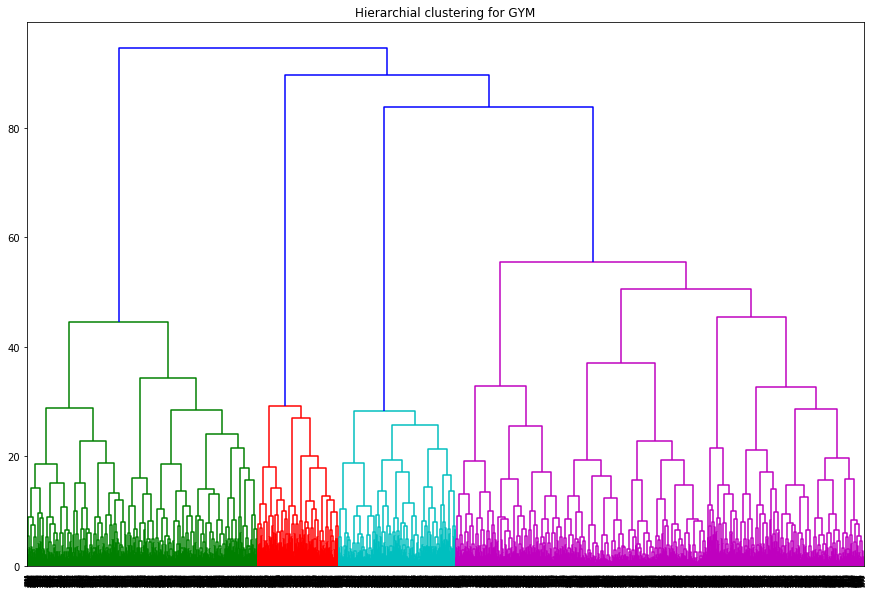

In [19]:
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

**Анализ дендограммы**

- Наименьшее возможное число кластеров, выделяемое дендограммой, равно 4.
- *(ТЗ проектной работы предлагает импользовать 5 кластеров. Мы создадим деление на 4 и 5 кластеров соответственно и сравним результаты)*

Разделим матрицу данных на 4 и 5 классов. Для того, что бы выбрать итоговое количество кластеров поспользуемся метрикой силуэта. Таким образом мы сократим время, которое понадобилось бы на осмотр признаков для двух вариантов классификаций.

Выберем количество кластеров и оценим и оценим:
- средние значения признаков
- распределение признаков
- долю оттока

In [20]:
km = KMeans(n_clusters = 5, random_state = 100) 
labels = km.fit_predict(x_sc)

km2 = KMeans(n_clusters = 4, random_state = 100)
labels2 = km2.fit_predict(x_sc)

In [21]:
from sklearn.metrics import silhouette_score

print('Silhouette_score for 5 clusters: {:.2f}'.format(silhouette_score(x_sc, labels)))

print('Silhouette_score for 4 clusters: {:.2f}'.format(silhouette_score(x_sc, labels2)))

Silhouette_score for 5 clusters: 0.13
Silhouette_score for 4 clusters: 0.17


- Для деления на 4 кластера метрика силуэта немного выше, поэтому будем пользоваться делением на 4 потенциальные группы.
- Надо принимать во внимание, что значение самой метрики среднее и кластеры получились диффузными. Объект из каждого отдельно взятого кластера не сильно отличается от объектов других кластеров.

In [22]:
gym['cluster'] = labels2
gym.groupby('cluster').mean()


,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,0.266839
1,0.499109,0.000000,0.488414,0.076649,1.0,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,0.399287
2,0.529083,1.000000,0.168345,0.062640,1.0,0.394295,28.963647,142.782276,2.820470,3.307606,1.848885,0.336130
3,0.484585,0.996047,0.940711,0.759684,1.0,0.511462,29.666403,157.830750,7.053755,4.543083,1.977348,0.105138


In [23]:
print('доля оттока в каждом кластере')
gym.groupby('cluster').apply(lambda gym: len(gym[gym['churn'] == 1]) / len(gym)) 


доля оттока в каждом кластере


cluster
0    0.266839
1    0.399287
2    0.336130
3    0.105138
dtype: float64

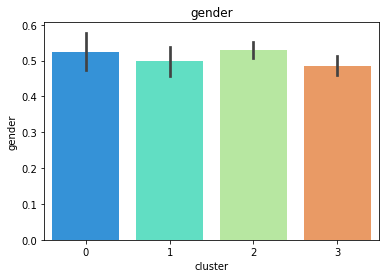

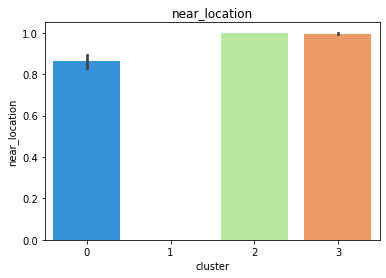

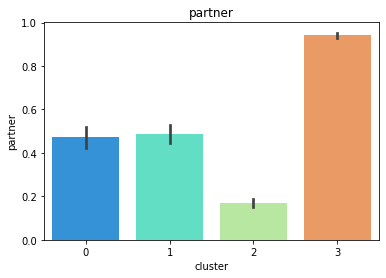

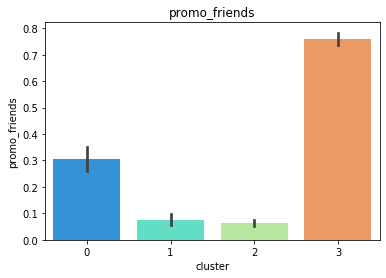

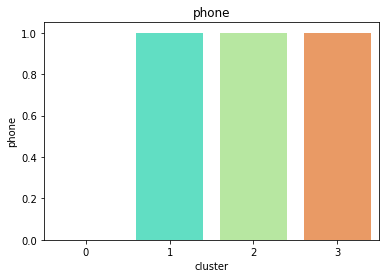

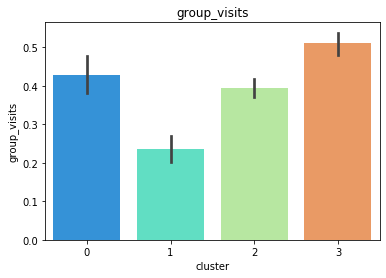

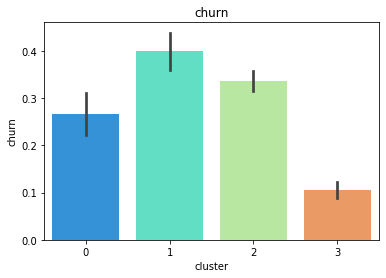

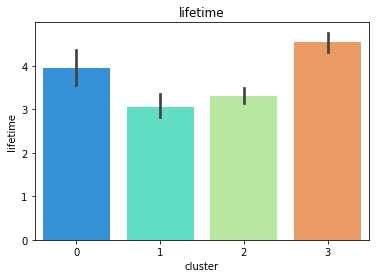

In [25]:
categorical = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn', 'lifetime']

continuous = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total']

for el in categorical:
    sns.barplot(x='cluster', y= el, data=gym, palette='rainbow')
    plt.title(el)
    plt.show()

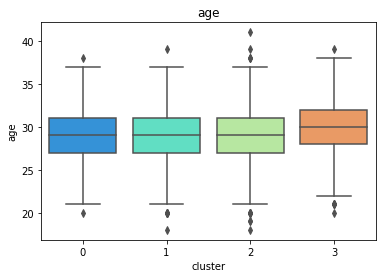

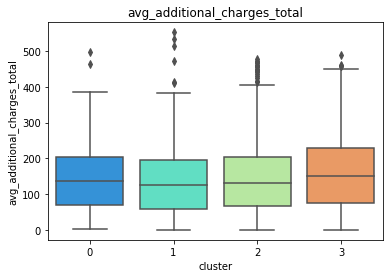

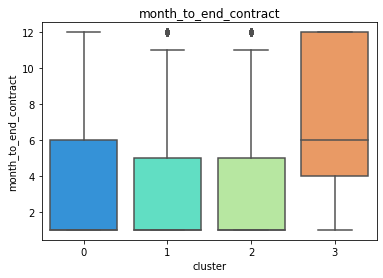

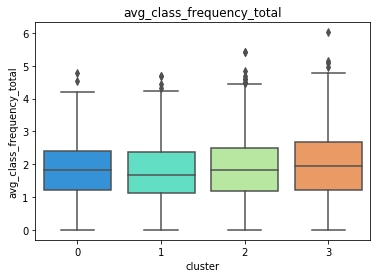

In [26]:
for el in continuous:
    sns.boxplot(x='cluster', y= el, data=gym, palette='rainbow')
    plt.title(el)
    plt.show()

Среди выделенных кластеров не бросается в глаза какое-то резкое различие. Признаки разделены без значимого разброса.

В кластере 1, с котором самая большая доля пользователей, попавших в отток:
- все живут далеко от фитнесс-центра
- дали контактный телефон и около половины ходят по партнерскому абонементу
- крайне мало пользователей, пришедших с другом
- Возраст, траты на прочие услуги, срок истечения контракта и жизненный цикл не выделяются значимо на фоне других кластеров

В кластере 3, с наименьшей долей клиентов, попавших в отток:

- почти все участники живут/работают близко к центру
- среди них так же больше всего клиентов по партнерскому абонементу и пришедших с другом
- около половины посещают групповые занятия
- у клиентов этого кластера больше всего месяцев до окончания контракта (в среднем на 4 месяца больше!)
- наиболее продолжительный жизненныйк цикл (4 месяца)
- в среднем их траты на прочие услуги больше

Кластеры 0 и 2 разделены слабо и имеют смешанные выразительные черты.

1 и 3 кластеры можно характеризовать слуюющим образом:

 - В кластере 0 клиенты, имеющие мало "связи" с центром. Живут далеко, абонемент не связан с работой или походами в центр с друзьями. Жизненный цикл у них не прожолжительный.
 - в кластере 1 оказались "долгожитили". Клиенты из этой группы давно ходят, посещают групповые занятия, живут или работают рядом с центром. Так же их посещаемость, возможно, поддерживают друзья или коллеги (партнерский абонемент). 

# Вывод

В данной работе мы оценивали признаки клиентов, попадающих в отток и настраивали алгоритм предсказания ухода клиентов.

 - Предварительно обработали данные
 - Оценили признаки постоянных и уходящих клиентов, сделали предварительные выводы
 - Подготовили данные для передачи алгоритмам классификации и кластеризации
 - Обучили алгоритмы классификации и оценили метриками качество их работы, выбрав наиболее подходящую ддя наших целей
 - Попробовали разделить пользователей на кластеры и оценить качество деления.
 
 
 
**Характерные черты клиента, попадающего в отток:**

- Живет/работает далеко от фитнесс-центра
- Пришел не по акции с другом и не по партнерскому абонементу
- Берет абонемент на месяц
- В среднем ходит 1 раз в неделю, редко посещает групповые занятия, в следствие чего меньше тратит на прочие услуги клуба

**Возможные стратегии по снижению оттока:**

- Акции/особые предложения на абонементы на 3-6 месяцев. 
- Расширение количества компаний-партнеров, сотрудникам которых предоставляются скидки на абонемент.
- Продвижение групповых занятий.
- Акции, поддерживающие регулярную посещаемость, помогающие клиентам выработать привычку занятий и не "бросать".